# 0.0 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 0.1 Data Load

In [2]:
df_raw = pd.read_csv('../../projeto/data_raw/POS_CASH_balance.csv')

In [3]:
df_train = pd.read_csv('../../projeto/data_raw/application_train.csv')

In [4]:
df_description = pd.read_csv('../../projeto/data_raw/HomeCredit_columns_description.csv', encoding='latin1', index_col = 0)

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head().T

,0,1,2,3,4
SK_ID_PREV,1803195,1715348,1784872,1903291,2341044
SK_ID_CURR,182943,367990,397406,269225,334279
MONTHS_BALANCE,-31,-33,-32,-35,-35
CNT_INSTALMENT,48.0,36.0,12.0,48.0,36.0
CNT_INSTALMENT_FUTURE,45.0,35.0,9.0,42.0,35.0
NAME_CONTRACT_STATUS,Active,Active,Active,Active,Active
SK_DPD,0,0,0,0,0
SK_DPD_DEF,0,0,0,0,0


## 1.1 Feature description

In [7]:
pd.set_option('display.max_colwidth', None)
df_description.loc[ df_description['Table'] == 'POS_CASH_balance.csv' ].reset_index(drop = 1).head(50)

,Table,Row,Description,Special
0,POS_CASH_balance.csv,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",NaN
1,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,POS_CASH_balance.csv,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
3,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
4,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
5,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
6,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previous credit,NaN
7,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,NaN


## 1.2 Data shape

In [8]:
df1.shape

(10001358, 8)

## 1.3 Check NaN

In [9]:
df1.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

## 1.4 Describe

In [10]:
df1.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


# 2.0 Feature Engineering

In [11]:
df2 = df1.copy()

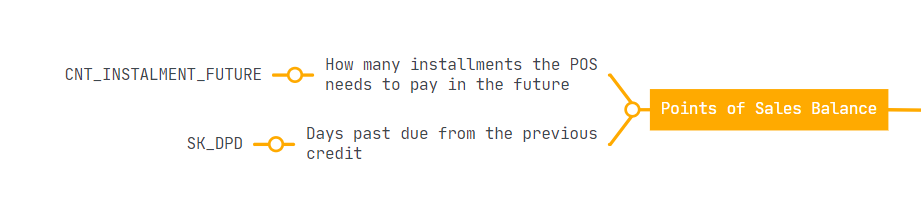

The features and EDA of credit card balance will be developed taking into consideration the business assumptions

In [12]:
df2.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [13]:
def installments_payments_feature_engineering(df_cleaned):

    df_featured = df_cleaned.copy()

    df_featured = df_featured.sort_values(['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], ascending = [True,True,False])

    df_featured = df_featured.groupby(['SK_ID_CURR']).agg(FUTURE_INSTALLMENTS_POS = ('CNT_INSTALMENT_FUTURE','last'),
                                                          SK_DPD_POS = ('SK_DPD','last'),
                                                          SK_PREV_POS = ('SK_ID_PREV','count')
                                                          ).reset_index()

 
    return df_featured

In [14]:
def join_train_installments(df_train, df_installments):

    df_train = df_train[['SK_ID_CURR','TARGET']]

    df_merged = df_train.merge(df_installments, on = 'SK_ID_CURR', how = 'left', validate = 'one_to_one')

    return df_merged

In [15]:
def feature_analysis(df_final):

    df_analysis = df_final.copy()

    for col in df_analysis.select_dtypes('number').columns:
        if col not in ['SK_ID_CURR','TARGET']:	
            col_name = f'{col}_q'
            df_analysis[col_name] = pd.qcut(df_analysis[col], q = 4, duplicates='drop',labels=False)
            df_analysis.groupby(col_name)['TARGET'].mean().plot()
            plt.axhline(df_analysis['TARGET'].mean(), color = 'red', linestyle = '--')
            plt.ylim(bottom =0)
            plt.title(col)
            plt.show()


In [16]:
df_featured = installments_payments_feature_engineering(df2)

In [17]:
df_final = join_train_installments(df_train, df_featured)

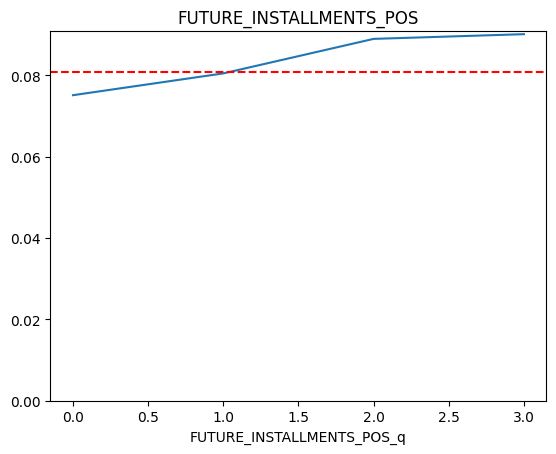

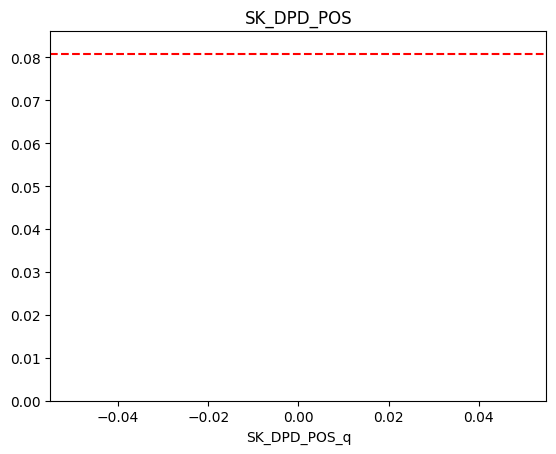

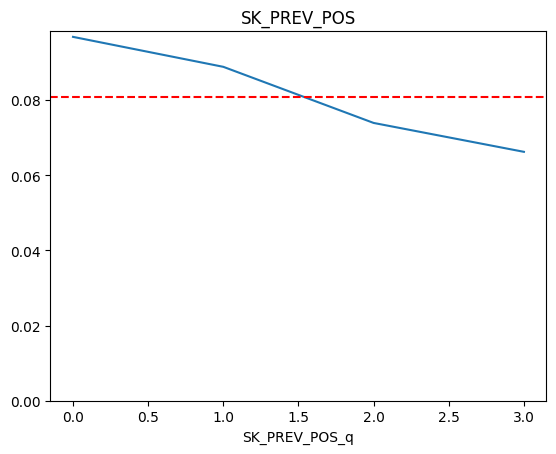

In [18]:
feature_analysis(df_final)

In [19]:
df_featured.to_parquet('../../projeto/data_featured/pos_cash.parquet')